In [1]:
# import libraries
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# read in data
df_diabetes = pd.read_csv('C:\\Users\\Kevin Sharp\\Desktop\\Springboard\\2014_BRFSS_encoded.csv')
df_diabetes.head()

,general_health,10yr_age_group,bmi_category,last_checkup,income,race,mscode,flushot,employed,sex,...,mental_health_days_per_month,kidney_disease,depressive_disorder,uses_medical_equipment,rent_or_own_home,any_exercise,blindness,trouble_concentrating,diabetes,smoker
0,5.0,4,3.0,1.0,7.0,7.0,5.0,1.0,8.0,2,...,2,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,3.0
1,1.0,3,4.0,1.0,7.0,1.0,3.0,2.0,1.0,1,...,1,2.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,3.0
2,3.0,4,4.0,1.0,4.0,1.0,2.0,1.0,7.0,2,...,1,2.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,4.0
3,3.0,6,4.0,1.0,6.0,2.0,3.0,1.0,7.0,1,...,2,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,4.0
4,2.0,4,3.0,1.0,8.0,1.0,3.0,2.0,7.0,1,...,1,2.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,3.0


For this project, I will be build logistic regression model to predict the risk of diabetes in responants to the 2014 BRFSS. Those with diabetes make up a minority of both the general population and the sample data, which will affect how I approach contructing the model.

In [2]:
#"no" response was encoded as 3; change these to 0 for clarity
df_diabetes.loc[(df_diabetes['diabetes'] == 3), 'diabetes'] = 0

#verify unbalanced nature of the data
df_diabetes['diabetes'].value_counts()/df_diabetes.shape[0]

0.0    0.844994
1.0    0.155006
Name: diabetes, dtype: float64

First, we split the data into training and testing sets. I use the default 25/75 ratio of training data to testing data.

In [3]:
#create train-test split
from sklearn.model_selection import train_test_split

X = df_diabetes.drop('diabetes', axis=1)
y = df_diabetes['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [4]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

def compute_model_performance(clf, scoring='roc_auc'):
    y_pred = clf.predict(X_test)
    print(f'roc_auc score: {np.mean(cross_val_score(clf, X_train, y_train, scoring=scoring, cv=5))}')
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Initially, I use a basic logistic regression model with no additional parameters to use as a control for the tuning I expect to perform at a later step. As a reminder, 0 indicates a diabetes negative response, while 1 indicates a diabetes positive response.

In [5]:
#establishing baseline naive model to use as a control for further tuning

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

compute_model_performance(clf)

roc_auc score: 0.8011254254137936
[[28715   705]
 [ 4557   840]]
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     29420
         1.0       0.54      0.16      0.24      5397

    accuracy                           0.85     34817
   macro avg       0.70      0.57      0.58     34817
weighted avg       0.81      0.85      0.81     34817



The printed table of metrics shows us the effect of modeling unbalanced data. Although the model's accuracy is a fine 85%, we find a recall of only 16% for those with diabetes; in other words, the remaining 84% of those with diabetes were reported as false negatives by the model. Since we are primarily interested in identifying those with diabetes, I will retune the model to assign class weights proportional to their frequency in the data.

In [6]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)

compute_model_performance(clf)

roc_auc score: 0.8013906212426782
[[20819  8601]
 [ 1464  3933]]
              precision    recall  f1-score   support

         0.0       0.93      0.71      0.81     29420
         1.0       0.31      0.73      0.44      5397

    accuracy                           0.71     34817
   macro avg       0.62      0.72      0.62     34817
weighted avg       0.84      0.71      0.75     34817



Already, we see a marked improvement in the rate of recall, and the ROC AUC score remains about the same at roughly 0.80. Accuracy drops to 71%, but since the model is now more consistently identifying true positives, I consider this a net improvement. I will next attempt to tune the model further by adjusting the regularization parameter $C$. I also provide a range of possible weights to allow the model more flexibility.

In [7]:
#create hyperparameter grid for grid search CV 
from sklearn.model_selection import GridSearchCV

Cs = [0.001, 0.1, 1, 10, 100]
Ws = [{1:84.4994, 0:15.5006}, {1:84, 0:16}, {1:80, 0:20}, {1:75, 0:25}]
hyperparam_grid = {"C":Cs, "class_weight":Ws}

In [8]:
clf = LogisticRegression(max_iter=1000)

grid = GridSearchCV(clf, hyperparam_grid, scoring='roc_auc')
grid.fit(X_train, y_train)
print(f'best score: {grid.best_score_}\nbest parameters: {grid.best_params_}')

best score: 0.8014044223990806
best parameters: {'C': 100, 'class_weight': {1: 80, 0: 20}}


In [9]:
C = grid.best_params_['C']
class_weight = grid.best_params_['class_weight']

clf = LogisticRegression(max_iter=1000, class_weight=class_weight)
clf.fit(X_train, y_train)
compute_model_performance(clf)

roc_auc score: 0.8014033831450217
[[23083  6337]
 [ 2014  3383]]
              precision    recall  f1-score   support

         0.0       0.92      0.78      0.85     29420
         1.0       0.35      0.63      0.45      5397

    accuracy                           0.76     34817
   macro avg       0.63      0.71      0.65     34817
weighted avg       0.83      0.76      0.78     34817



This updated model uses a value of 0.1 for $C$ instead of the default 1 and adjusts the class weights a bit. Once again, the ROC AUC score is just over 0.80, and accuracy is increased from 72% to 76% without negatively affecting other scores too much. I believe this version of the model is sufficent to move forward with a final analysis of the predictor variables.

In [10]:
df_coef = pd.DataFrame()
df_coef['coefficients'] = clf.coef_[0]
df_coef['features'] = X.columns
df_coef = df_coef.loc[df_coef['coefficients'].abs().argsort()]

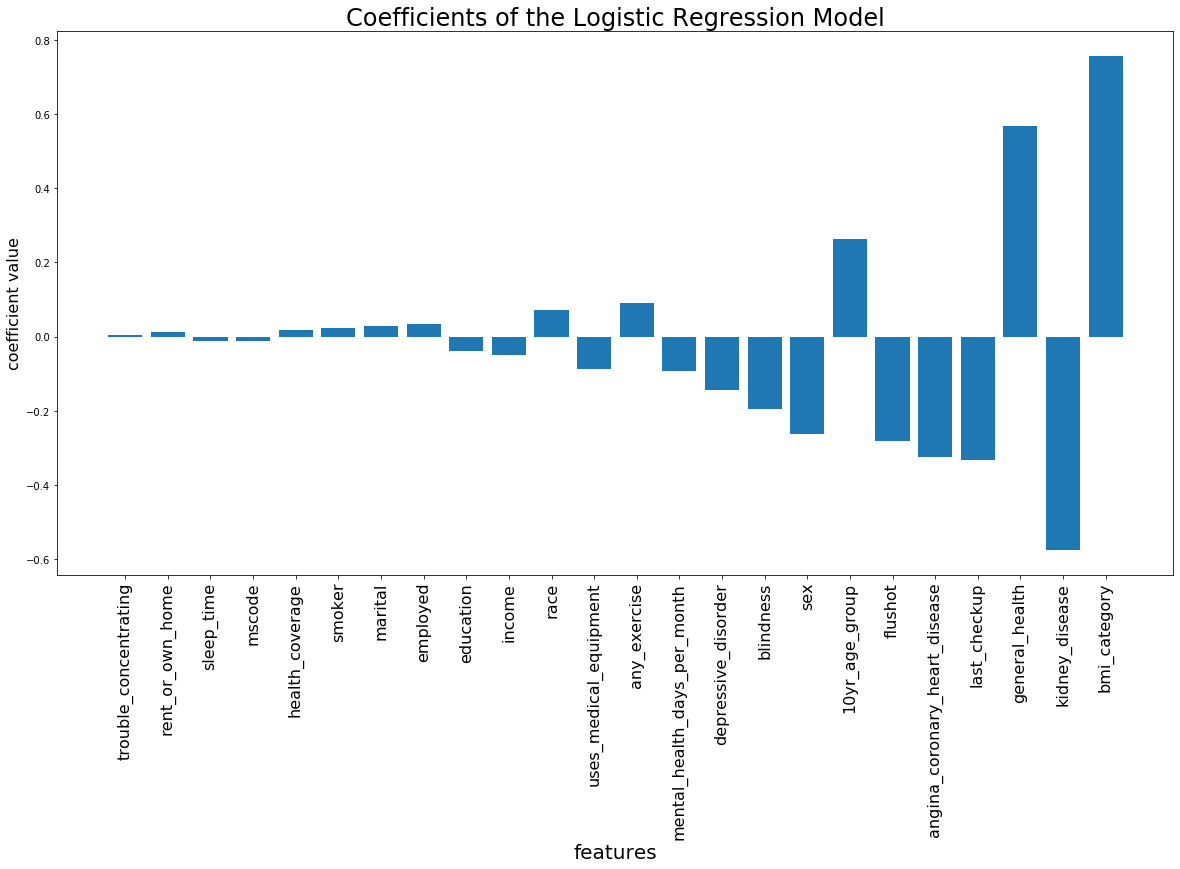

In [11]:
fig = plt.figure(figsize=(20,10))

plt.bar(df_coef['features'], df_coef['coefficients'])
plt.xticks(rotation=90, fontsize=16)
plt.title("Coefficients of the Logistic Regression Model", fontsize=24)
plt.xlabel("features", fontsize=20)
plt.ylabel("coefficient value", fontsize=16)
plt.show()

Conclusions
---

As a reminder, the model itself does not establish the direction of causality between the predictors and the incidence of diabetes; conclusions about causality are derived from general medical knowledge about the causes and outcomes associated with diabetes.

Based on the results from the final version of thge model, the five strongest predictors for diabetes are `bmi_category`, `kidney_disease`, `general_health`, `last_checkup`, and `angina_coronary_heart_disease`. Predictably, as a person's weight increases and their general health worsens, do does their risk of diabetes. Kidney disease, angina, and coronary heart disease in general are negative health outcomes shown to be strong predictors of a prior onset of diabetes. Finally, as discussed in the section on exploratory data analysis, those with diabetes are perhaps more likely to vist their doctor frequently in order to monitor their condition.